# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.364046,True,3.010693
1,-0.164838,True,5.714681
2,-0.274911,False,2.042694
3,1.190484,True,6.563680
4,-0.501419,True,4.838374
...,...,...,...
995,0.153206,False,-0.583520
996,0.364438,True,4.679177
997,-0.628581,False,-1.075273
998,-2.349680,False,-1.636121


<AxesSubplot: xlabel='v0'>

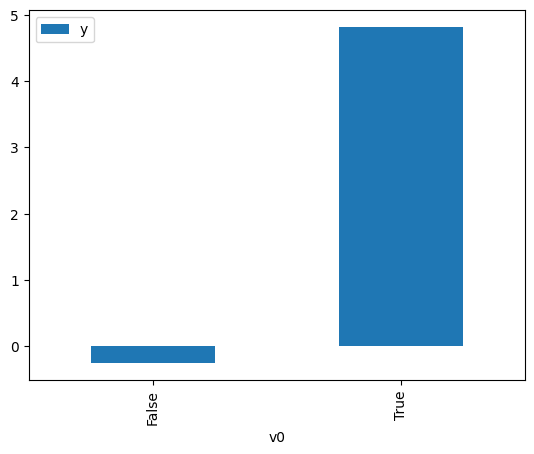

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

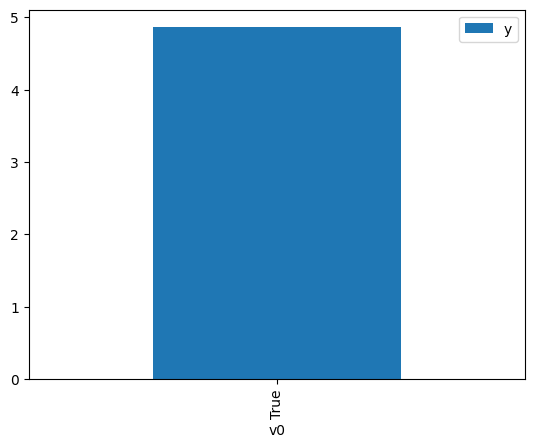

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.890372,False,-1.125757,0.984071,1.016187
1,-1.299153,False,-0.839480,0.944648,1.058595
2,-0.622242,False,-3.550111,0.796442,1.255584
3,1.780212,False,2.022782,0.020566,48.624026
4,0.084085,False,-0.998754,0.456931,2.188516
...,...,...,...,...,...
995,-0.067513,False,-0.017701,0.539209,1.854568
996,0.446865,False,-1.998950,0.276461,3.617142
997,1.780212,False,2.022782,0.020566,48.624026
998,-0.976149,False,-0.012622,0.894190,1.118330


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.258802,True,5.153557,0.938704,1.065298
1,1.376968,True,6.977646,0.951934,1.050493
2,0.784001,True,5.740126,0.844968,1.183477
3,-0.935740,True,4.276269,0.114422,8.739600
4,2.182757,True,6.543837,0.991331,1.008745
...,...,...,...,...,...
995,0.992650,True,6.848784,0.895638,1.116523
996,0.308151,True,5.562897,0.659317,1.516721
997,-0.501419,True,4.838374,0.249495,4.008089
998,0.233290,True,5.219962,0.621839,1.608132


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              6986.
Date:                Thu, 10 Nov 2022   Prob (F-statistic):                        0.00
Time:                        08:39:27   Log-Likelihood:                         -1389.1
No. Observations:                1000   AIC:                                      2782.
Df Residuals:                     998   BIC:                                      2792.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8806      0.033     27.013      0.000       0.817       0.945
x2             4.9200      0.049     99.418      0.000       4.823       5.017
==============================================================================
Omnibus:                        6.931   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                8.675
Skew:                          -0.074   Prob(JB):                       0.0131
Kurtosis:                       3.432   Cond. No.                         1.73
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""